In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings 
warnings.filterwarnings('ignore')

In [10]:

df = pd.read_csv('Downloads\Bitcoin.csv', usecols=['Date','Adj Close'])
df.columns = ['Date','Price']
variable='Price'
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014



Inference: The Datset consists of 1 features & 2683 samples.


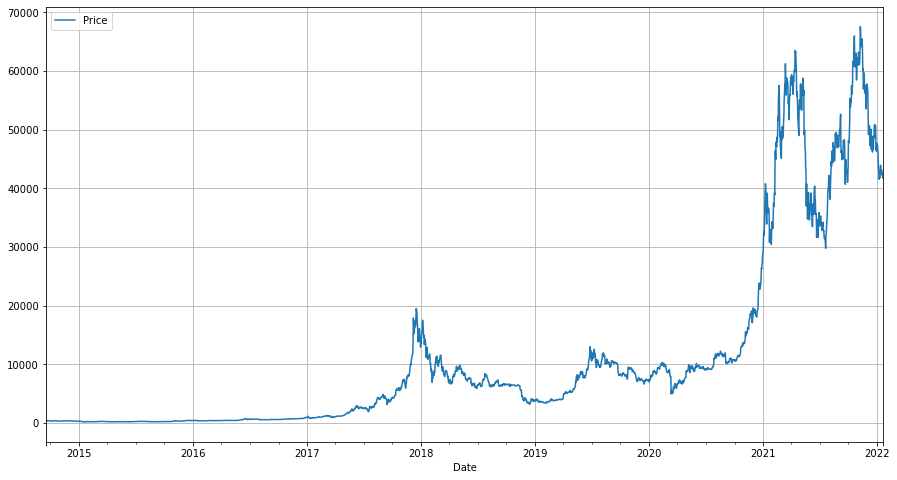

In [11]:
#Plotting Timeseries

df.plot()
plt.grid()
plt.show()

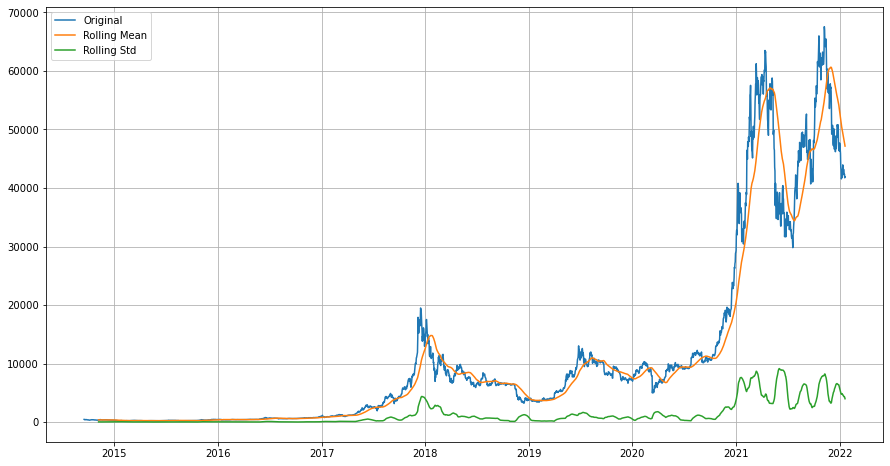

T Statistic             -1.138159
P-Value                  0.699617
#Lags Used              28.000000
#Observations Used    2654.000000
Critical value 1%       -3.432816
Critical value 5%       -2.862630
Critical value 10%      -2.567350
dtype: float64


In [13]:
#Stationary Check

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','#Lags Used','#Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(df[variable])

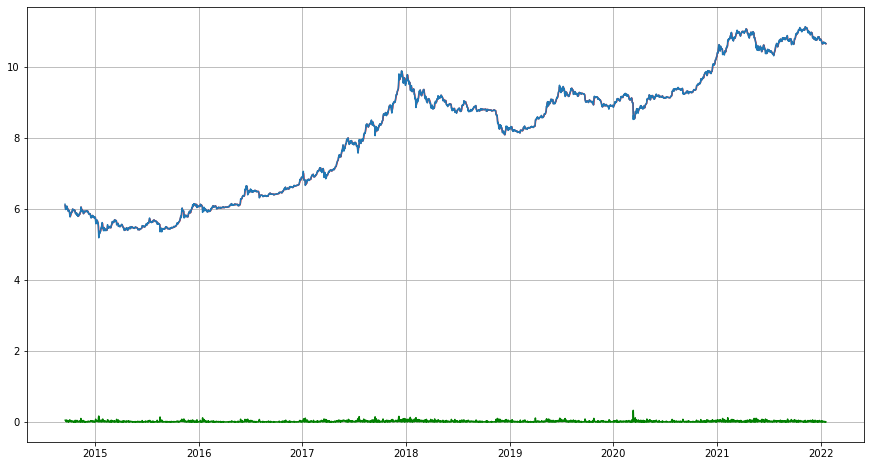

In [14]:
#Decomposing using moving average

tsl = np.log(df)
ma = tsl.rolling(window=2).mean()
ms = tsl.rolling(window=2).std()

plt.plot(ma, c='r')#, center=False)
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

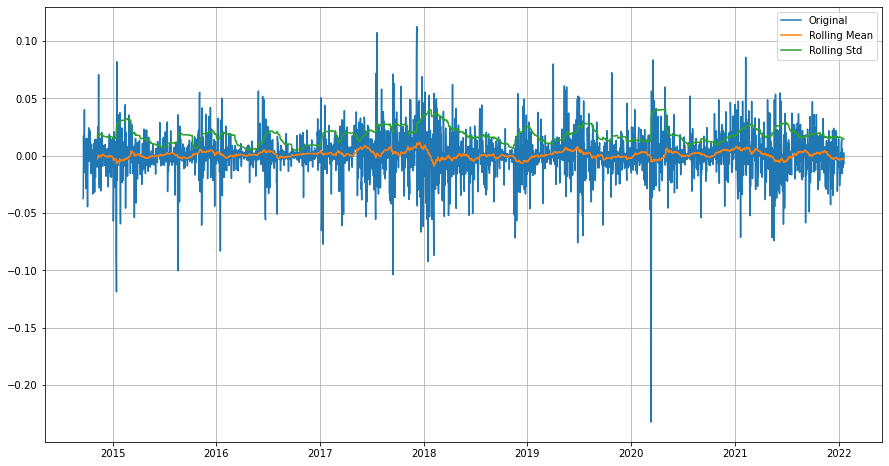

T Statistic          -1.554228e+01
P-Value               2.151715e-28
#Lags Used            9.000000e+00
#Observations Used    2.672000e+03
Critical value 1%    -3.432800e+00
Critical value 5%    -2.862622e+00
Critical value 10%   -2.567346e+00
dtype: float64


In [15]:
# Stationarity Check for Decomposed Time Series

tsl - np.log(df)
ma = tsl.rolling(window=2, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Staionarity_Check(tslma)

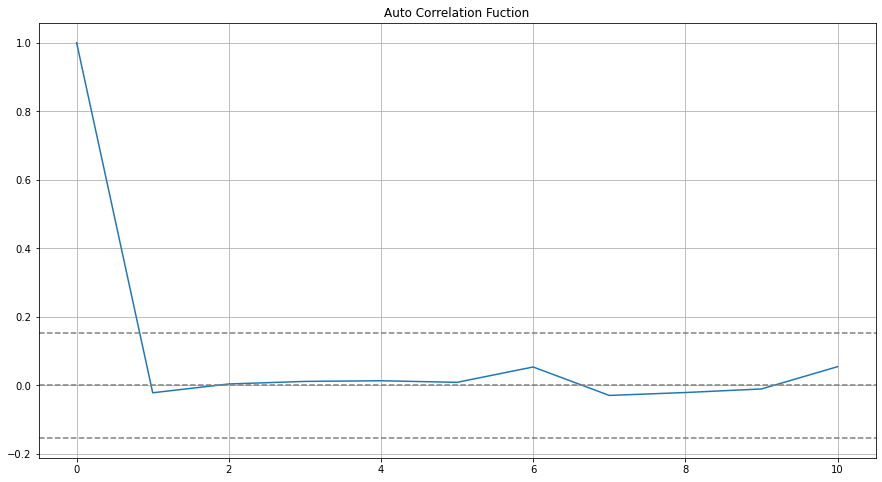

In [16]:
#Auto Correlation Fuction #q

plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

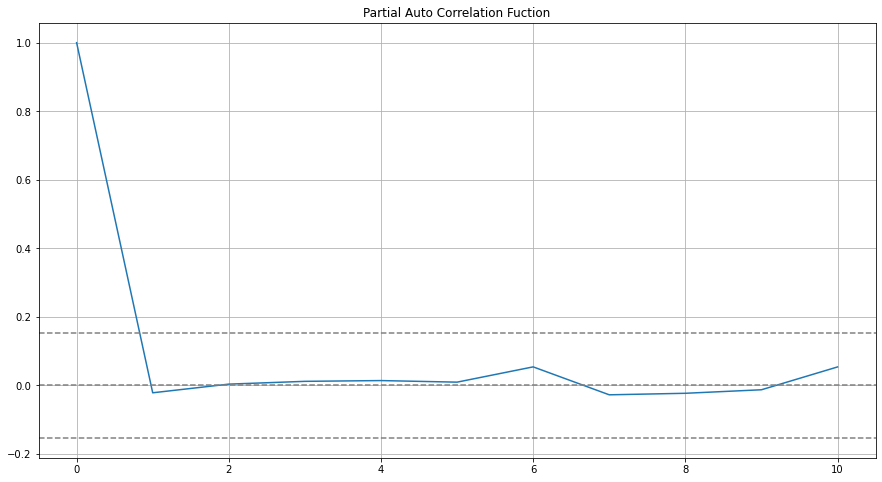

In [17]:
#Partial Auto Correlation Fuction #p

plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

In [18]:
#Building ARIMA Model

Arima = ARIMA(tslma, order=(1,2,2))
Ar = Arima.fit()
# plt.plot(tslma, label=['Original'])
# plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
# plt.legend()
# plt.grid()

Ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2682
Model:                 ARIMA(1, 2, 2)   Log Likelihood                6722.080
Date:                Thu, 03 Mar 2022   AIC                         -13436.160
Time:                        11:39:57   BIC                         -13412.586
Sample:                    09-18-2014   HQIC                        -13427.632
                         - 01-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0308      0.013     -2.407      0.016      -0.056      -0.006
ma.L1         -1.9900      0.002   -873.565      0.000      -1.994      -1.986
ma.L2          0.9900      0.002    434.462      0.000       0.986       0.995
sigma2         0.0004   4.28e-06     90.893      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             13786.71
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,1)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])
future_df.shape

(2683, 1)

In [20]:
Ar.predict(start =2500, end = 2600, dynamic= True)

2021-07-23   -0.000594
2021-07-24   -0.000488
2021-07-25   -0.000500
2021-07-26   -0.000508
2021-07-27   -0.000516
                ...   
2021-10-27   -0.001288
2021-10-28   -0.001296
2021-10-29   -0.001304
2021-10-30   -0.001313
2021-10-31   -0.001321
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

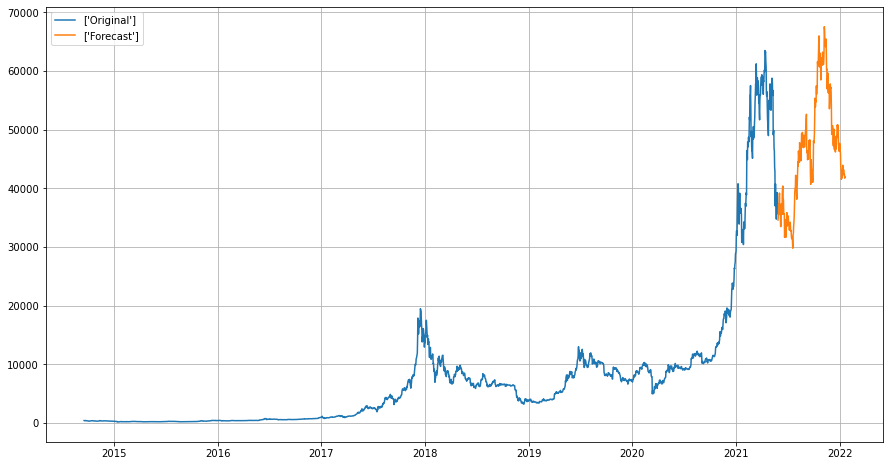

In [21]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Price'] += Ar.predict(start =0, end = 2683, dynamic= True)

plt.plot(future_df[variable][:-260], label=['Original'])
plt.plot((future_df['Price'][-260:]+(1.08*ma.mean()[0])), label=['Forecast'])
plt.grid()
plt.legend()
plt.show()